In [2]:
#!pip install fedot

In [6]:
import os
os.environ["MKL_NUM_THREADS"] = "10"
os.environ["NUMEXPR_NUM_THREADS"] = "10"
os.environ["OMP_NUM_THREADS"] = "10"

import torch
torch.set_num_threads(10)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
logging.raiseExceptions = False

import fedot
from fedot.api.main import Fedot
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import TsForecastingParams, Task, TaskTypesEnum
import inspect

In [5]:
from google.colab import files
uploaded = files.upload()

Saving ts study 1.txt to ts study 1.txt


In [7]:
ts_tabular =pd.read_csv('ts study 1.txt')
ts_real_temp = ts_tabular[ts_tabular['label']=='temp'].drop('label',axis=1)['value'].to_numpy()

In [27]:
def s1(n,noise = 3,sign=1):
    def f1(x):
        return 5*np.sin(x/20)+0.1*x-2*np.sqrt(x)
    trend = f1(np.array(range(n)))
    noise = np.random.normal(loc = 0, scale = noise,size = n)
    ans = {'ts':(trend+noise)*sign, 'trend' : trend*sign}
    return ans
def s2(length, periods = 10,noise = 0.3,sign=1 ):

    sinusoidal_data = np.linspace(-periods * np.pi, periods * np.pi, length)
    sinusoidal_data = np.sin(sinusoidal_data)
    cos_1_data = np.linspace(-periods * np.pi/2, periods/2 * np.pi/2, int(length/2))
    cos_1_data = np.cos(cos_1_data) 
    cos_2_data = np.linspace(periods/2 * np.pi/2, periods * np.pi/2, int(length/2))
    cos_2_data = np.cos(cos_2_data)   
    cosine_data = np.hstack((cos_1_data, cos_2_data))
    
    random_noise = np.random.normal(loc=0.0, scale=noise, size=length)
    synthetic_data = sinusoidal_data + cosine_data + random_noise
    ans = {'ts':synthetic_data*sign, 'trend': (sinusoidal_data + cosine_data)*sign}
    return ans
def s3(n,noise = 10,sign = 1):
    r = np.array(range(n))
    trend = (r-r/5*np.sin(r/2)+r/2*np.sin(r/20))/10
    noise = np.random.normal(loc=0,scale = noise,size = n)
    ans = {'ts':(trend+noise)*sign, 'trend': trend*sign}
    return ans
def s4(n,noise = 1,sign =1):
    array = np.array(range(n))
    trend = array/5+np.power(array,0.5)*np.sin(np.pi/12*array)
    noise = np.random.normal(loc = 0,scale = noise, size = n)
    noise_cum = noise.cumsum()
    ts = trend+noise_cum
    ans = {'ts':ts*sign, 'trend' : trend*sign}
    return ans

def s5(n,noise = 1,sign=1):
    r= np.arange(n)
    trend = r*1
    noise = np.random.normal(loc=0,scale = noise,size = n)
    noise_cum = noise.cumsum()
    ts = trend+noise_cum
    ans = {'ts':ts*sign,'trend':trend*sign}
    return ans

def s6(n,noise = 1, sign =1):
    r = np.arange(n)
    trend = 2*np.sin(2*r)+np.cos(r)
    noise = np.random.normal(loc = 0,scale  = noise,size = n)
    ts = trend+noise
    ans = {'ts':ts,'trend':trend}
    return ans

In [59]:
horizon = 30
validation_blocks = 2
task = Task(TaskTypesEnum.ts_forecasting,  TsForecastingParams(forecast_length=horizon))
start = 4000
end = 5000
series = 'traffic'

if series == 'traffic':
    init_series = ts_real_temp
    ts = init_series[start:end]
    trend = None
    ts_test = init_series[end:end+horizon]
    trend_test = None

if series ==1:
    noise = 0.5
    init_series = s1(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]  
    
if series ==2:
    noise = 0.5
    init_series = s2(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
    
if series ==3:
    noise = 0.5
    init_series = s3(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
    
if series ==4:
    noise = 0.5
    init_series = s4(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
  
if series ==5:
    noise = 1
    init_series = s5(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]   

if series ==6:
    noise = 0.5
    init_series = s6(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
 
idx = np.array( range(len(np.array(ts))) )
train_input = InputData(idx=idx,
                            features=ts,
                            target=ts,
                            task=task,
                            data_type=DataTypesEnum.ts)
train_data, test_data = train_test_data_setup(train_input, validation_blocks=2)

# init model for the time series forecasting
model = Fedot(problem='ts_forecasting',
                  safe_mode = True,
                  task_params=task.task_params,
                  timeout=3,
                  n_jobs=-1,
                  cv_folds=2, 
                  validation_blocks=2, 
                  preset='ts',
                  with_tuning = False,
                  max_depth = 5,
                  num_of_generations  =3 ,
                  logging_level = 10,
                 show_progress =True)

In [46]:
#inspect.getmembers(model)

INFO:root:AssumptionsHandler - Initial pipeline fitting started


2022-11-24 13:00:58,088 - AssumptionsHandler - Initial pipeline fitting started


DEBUG:root:SecondaryNode - Trying to fit secondary node with operation: ridge


2022-11-24 13:00:58,098 - SecondaryNode - Trying to fit secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 13:00:58,103 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Trying to fit secondary node with operation: ridge


2022-11-24 13:00:58,107 - SecondaryNode - Trying to fit secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 13:00:58,110 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:PrimaryNode - Trying to fit primary node with operation: lagged


2022-11-24 13:00:58,114 - PrimaryNode - Trying to fit primary node with operation: lagged


DEBUG:root:PrimaryNode - Trying to fit primary node with operation: glm


2022-11-24 13:00:58,231 - PrimaryNode - Trying to fit primary node with operation: glm


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 13:00:58,381 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 13:00:58,393 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 13:00:58,401 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 13:00:58,406 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:PrimaryNode - Predict in primary node by operation: lagged


2022-11-24 13:00:58,414 - PrimaryNode - Predict in primary node by operation: lagged


DEBUG:root:PrimaryNode - Predict in primary node by operation: glm


2022-11-24 13:00:58,424 - PrimaryNode - Predict in primary node by operation: glm


INFO:root:AssumptionsHandler - Initial pipeline was fitted successfully


2022-11-24 13:00:58,431 - AssumptionsHandler - Initial pipeline was fitted successfully


CRITICAL:root:ApiComposer - Initial pipeline was fitted in 0.3 sec.


2022-11-24 13:00:58,437 - ApiComposer - Initial pipeline was fitted in 0.3 sec.


CRITICAL:root:ApiComposer - AutoML configured. Parameters tuning: False Time limit: 3 min Set of candidate models: ['sparse_lagged', 'locf', 'stl_arima', 'sgdr', 'lagged', 'lasso', 'gaussian_filter', 'adareg', 'glm', 'arima', 'diff_filter', 'polyfit', 'pca', 'dtreg', 'scaling', 'fast_ica', 'ridge', 'cut', 'linear', 'normalization', 'ts_naive_average', 'smoothing', 'ets', 'ar']


2022-11-24 13:00:58,455 - ApiComposer - AutoML configured. Parameters tuning: False Time limit: 3 min Set of candidate models: ['sparse_lagged', 'locf', 'stl_arima', 'sgdr', 'lagged', 'lasso', 'gaussian_filter', 'adareg', 'glm', 'arima', 'diff_filter', 'polyfit', 'pca', 'dtreg', 'scaling', 'fast_ica', 'ridge', 'cut', 'linear', 'normalization', 'ts_naive_average', 'smoothing', 'ets', 'ar']


CRITICAL:root:ApiComposer - Pipeline composition started.


2022-11-24 13:00:58,493 - ApiComposer - Pipeline composition started.


INFO:root:DataSourceSplitter - K-folds cross validation is applied.


2022-11-24 13:00:58,496 - DataSourceSplitter - K-folds cross validation is applied.


Generations:  33%|███▎      | 1/3 [00:00<?, ?gen/s]INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-24 13:00:58,502 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 1


2022-11-24 13:01:06,053 - EvoGraphOptimizer - Generation num: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 4.859802569640648, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


2022-11-24 13:01:06,067 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 4.859802569640648, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


INFO:root:EvoGraphOptimizer - no improvements for 0 iterations


2022-11-24 13:01:06,071 - EvoGraphOptimizer - no improvements for 0 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.1 min


2022-11-24 13:01:06,075 - EvoGraphOptimizer - spent time: 0.1 min


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-24 13:01:07,864 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 2


2022-11-24 13:01:24,525 - EvoGraphOptimizer - Generation num: 2


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 4.5679684857525, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


2022-11-24 13:01:24,530 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 4.5679684857525, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


INFO:root:EvoGraphOptimizer - no improvements for 0 iterations


2022-11-24 13:01:24,535 - EvoGraphOptimizer - no improvements for 0 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.4 min


2022-11-24 13:01:24,539 - EvoGraphOptimizer - spent time: 0.4 min


INFO:root:EvoGraphOptimizer - Next population size: 34; max graph depth: 5


2022-11-24 13:01:24,543 - EvoGraphOptimizer - Next population size: 34; max graph depth: 5


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-24 13:01:25,425 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 3


2022-11-24 13:01:44,919 - EvoGraphOptimizer - Generation num: 3


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 4.5679684857525, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


2022-11-24 13:01:44,927 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 4.5679684857525, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2022-11-24 13:01:44,931 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.8 min


2022-11-24 13:01:44,934 - EvoGraphOptimizer - spent time: 0.8 min


INFO:root:EvoGraphOptimizer - Next population size: 55; max graph depth: 5


2022-11-24 13:01:44,938 - EvoGraphOptimizer - Next population size: 55; max graph depth: 5


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-24 13:01:46,232 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 4


2022-11-24 13:02:03,038 - EvoGraphOptimizer - Generation num: 4


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 4.5679684857525, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


2022-11-24 13:02:03,046 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 4.5679684857525, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


INFO:root:EvoGraphOptimizer - no improvements for 2 iterations


2022-11-24 13:02:03,051 - EvoGraphOptimizer - no improvements for 2 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.1 min


2022-11-24 13:02:03,057 - EvoGraphOptimizer - spent time: 1.1 min


CRITICAL:root:GroupedCondition - Optimisation stopped: Max number of generations reached


2022-11-24 13:02:03,061 - GroupedCondition - Optimisation stopped: Max number of generations reached


Generations:  33%|███▎      | 1/3 [01:04<?, ?gen/s]
INFO:root:OptimisationTimer - Composition time: 1.076 min


2022-11-24 13:02:03,065 - OptimisationTimer - Composition time: 1.076 min


INFO:root:GPComposer - GP composition finished


2022-11-24 13:02:03,071 - GPComposer - GP composition finished


CRITICAL:root:ApiComposer - Model generation finished


2022-11-24 13:02:03,389 - ApiComposer - Model generation finished


CRITICAL:root:FEDOT logger - Final pipeline was fitted


2022-11-24 13:02:03,638 - FEDOT logger - Final pipeline was fitted


CRITICAL:root:FEDOT logger - Final pipeline: {'depth': 3, 'length': 4, 'nodes': [ridge, glm, ridge, lagged]}


2022-11-24 13:02:03,645 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 4, 'nodes': [ridge, glm, ridge, lagged]}


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 13:02:03,652 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 13:02:03,657 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 13:02:03,660 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 13:02:03,663 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:PrimaryNode - Predict in primary node by operation: lagged


2022-11-24 13:02:03,666 - PrimaryNode - Predict in primary node by operation: lagged


DEBUG:root:PrimaryNode - Predict in primary node by operation: glm


2022-11-24 13:02:03,672 - PrimaryNode - Predict in primary node by operation: glm


2022-11-24 13:02:03,733 - OperationTypesRepository - Operation lagged not found in the repository


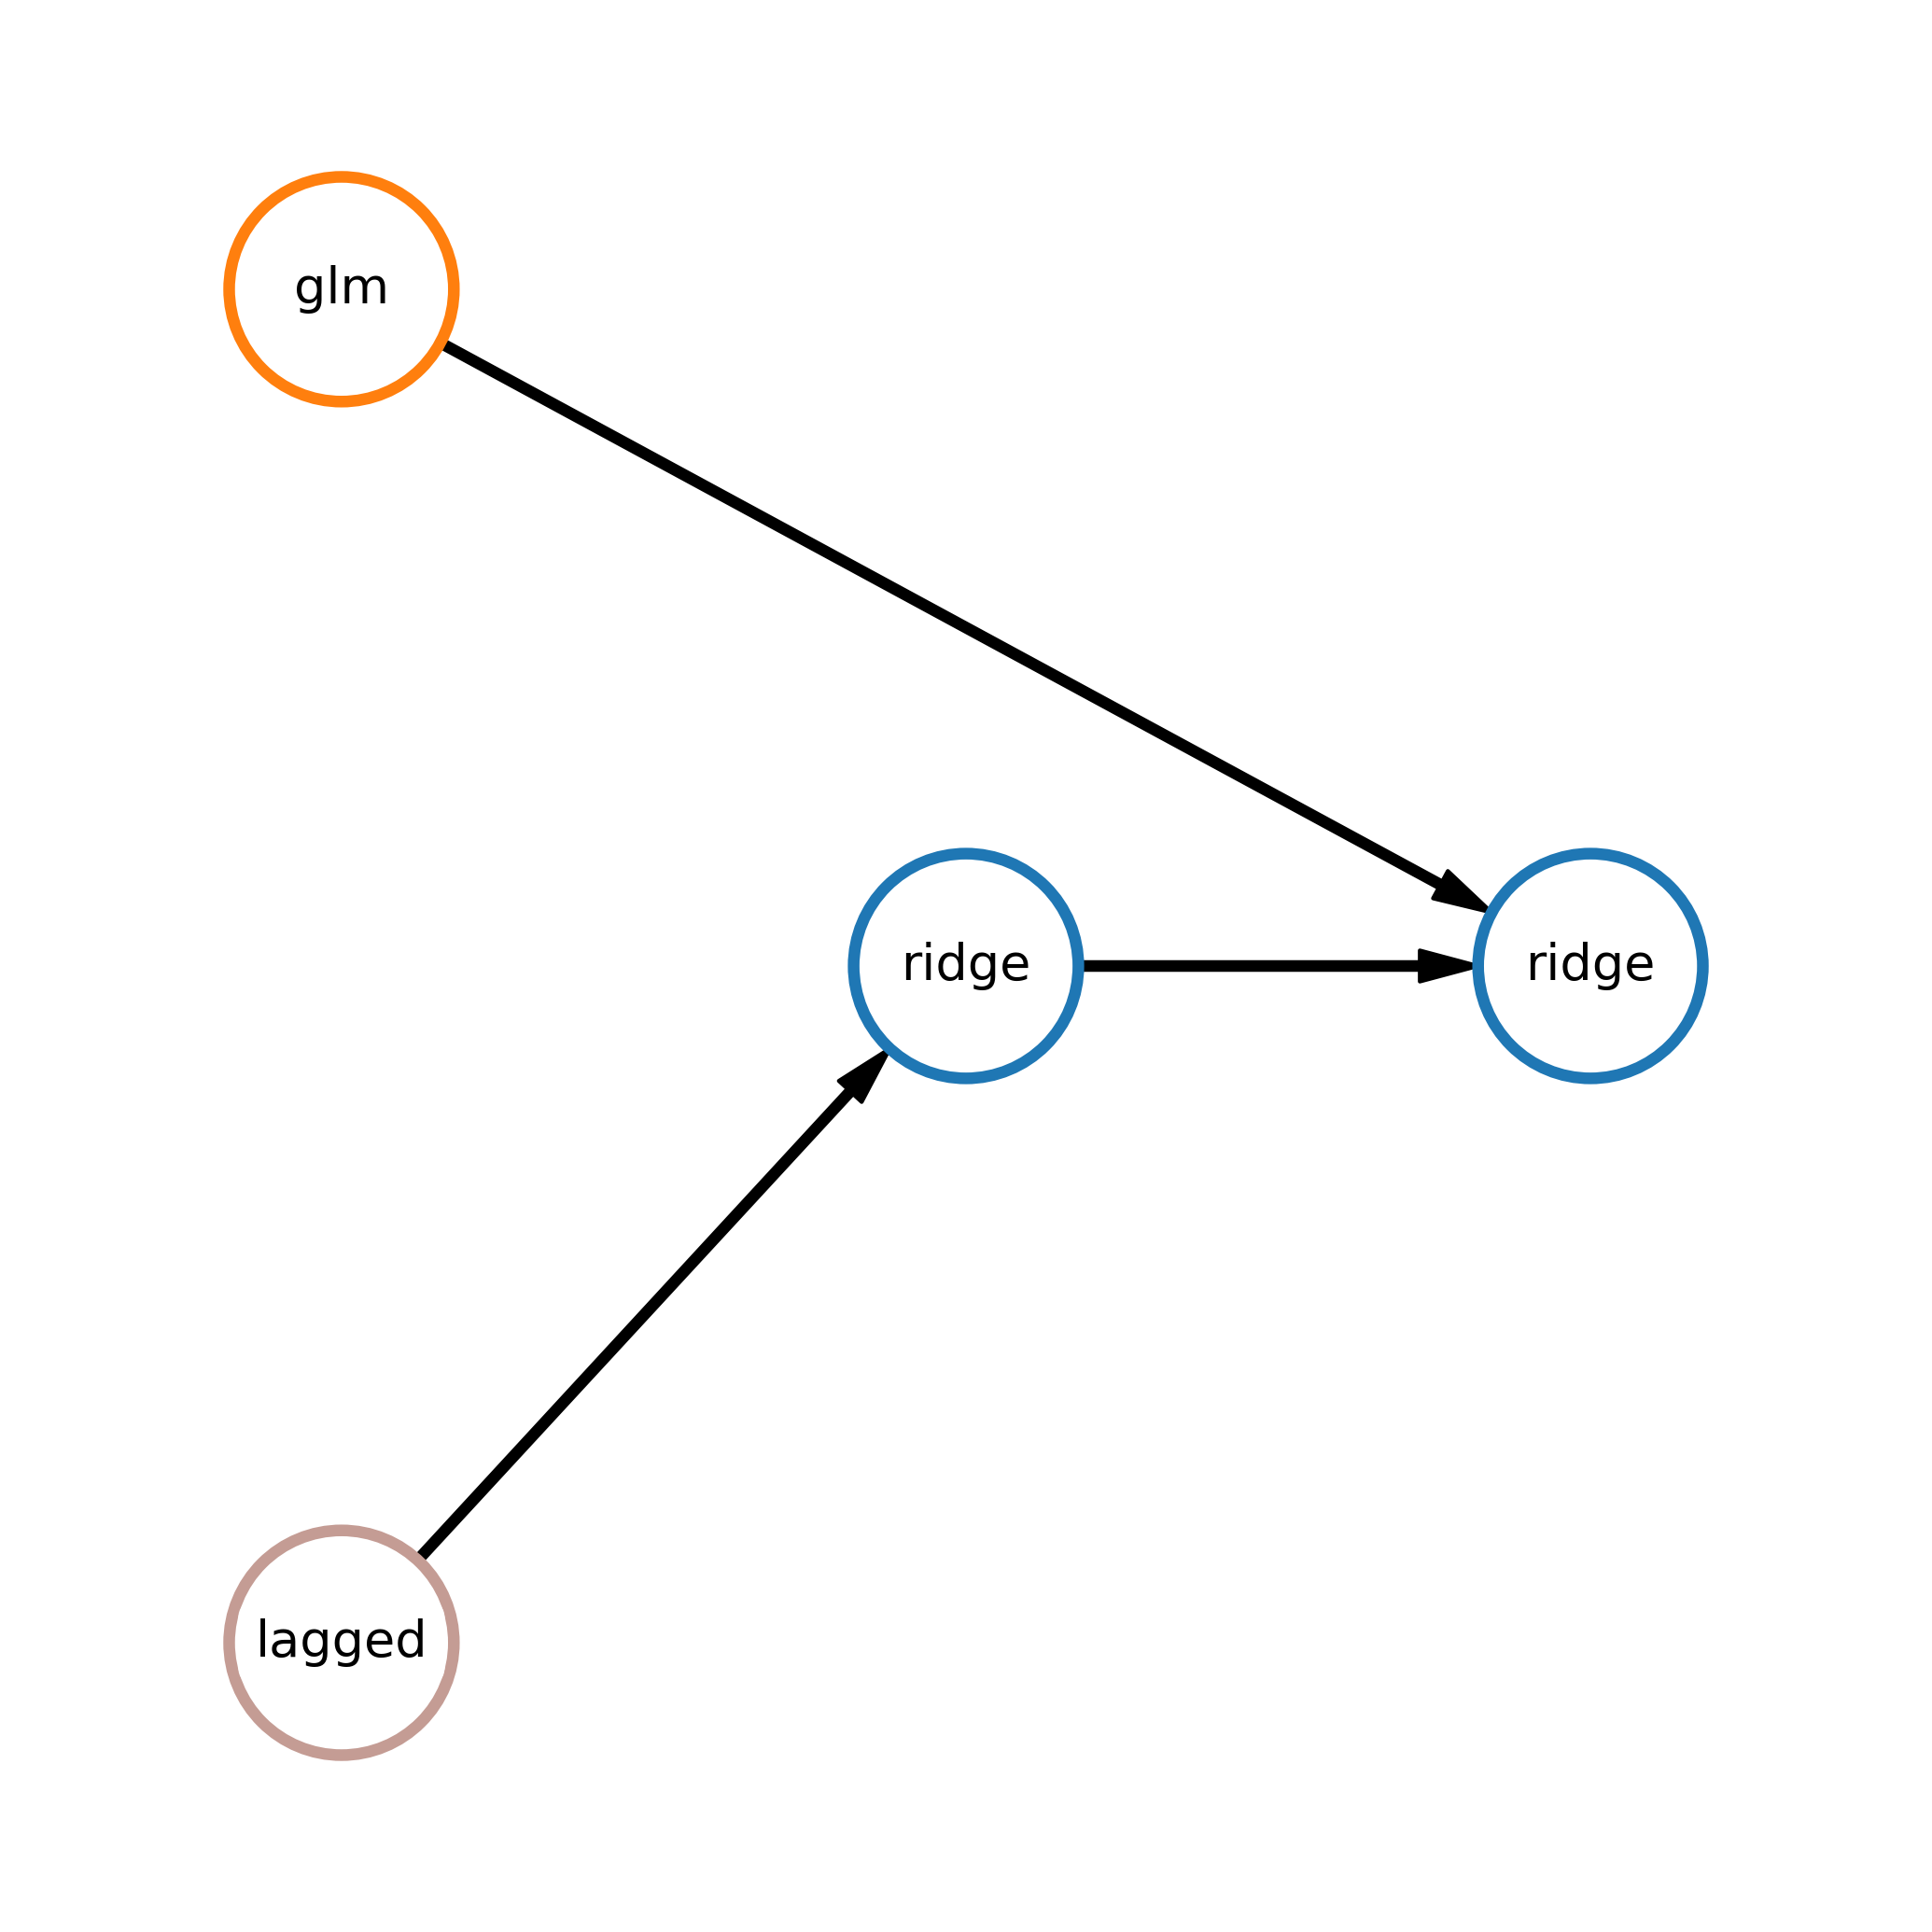

In [60]:
pipeline = model.fit(train_data)
forecast = model.forecast(test_data)
pipeline.show()

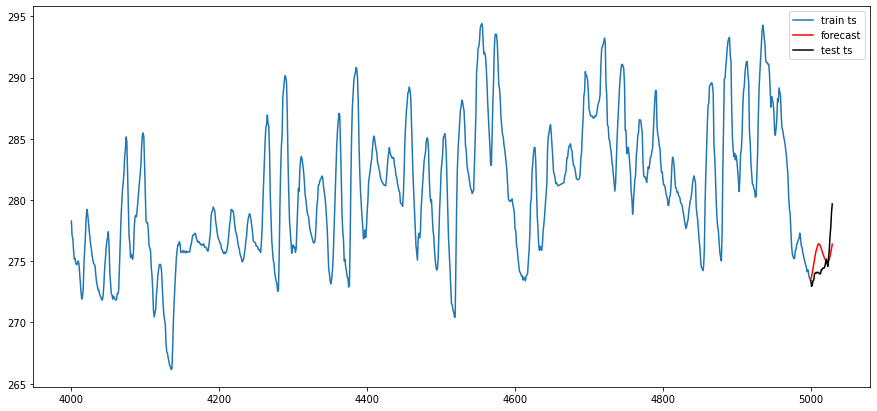

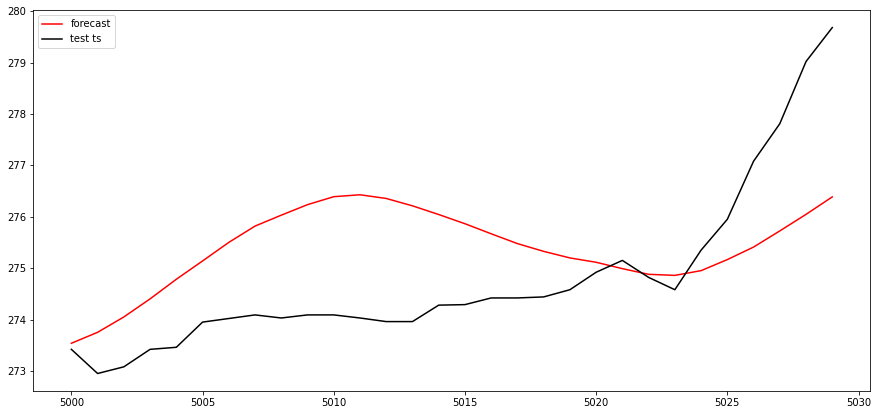

In [61]:
fig,ax  = plt.subplots()
fig.set(figwidth = 15,figheight = 7)
test_range = range(len(ts), len(ts)+len(ts_test))
test_range = range(end,end+horizon)
train_range = range(start,end)
total_range = range(start,end+horizon)

ax.plot(train_range,ts, label = 'train ts')
if trend is not None:
    ax.plot(train_range, trend,color = 'green',label = 'trend')
if trend_test is not None:
    ax.plot(test_range, trend_test,color = 'green')
ax.plot(test_range,forecast, color = 'red', label = 'forecast')
ax.plot(test_range, ts_test,color = 'black', label = 'test ts')
plt.legend();

fig1,ax1 = plt.subplots()
fig1.set(figwidth = 15,figheight = 7)

if trend_test is not None:
    ax1.plot(test_range, trend_test,color = 'green')
ax1.plot(test_range,forecast, color = 'red', label = 'forecast')
ax1.plot(test_range, ts_test,color = 'black', label = 'test ts')
plt.legend();

In [62]:
import sys
from sklearn.metrics import mean_squared_error as mse
from fedot.core.composer.metrics import QualityMetric
from fedot.core.data.data import InputData, OutputData
from fedot.core.repository.tasks import TsForecastingParams

def quantile_loss(y_true, y_pred, quantile=0.5):
    res = np.array(y_true)-np.array(y_pred)
    metrics=np.empty(shape = [0])
    for x in res:
        if x>=0:
            metrics = np.append(metrics, quantile*x)
        else:
            metrics = np.append(metrics,(quantile-1)*x)
    return np.mean(metrics)

class Quantile_Loss_1(QualityMetric):
    default_value = sys.maxsize

    @staticmethod
    def metric(reference: InputData, predicted: OutputData) -> float:
        value = quantile_loss(reference.target, predicted.predict,quantile = 0.1)
        return value


class Quantile_Loss_9(QualityMetric):
    default_value = sys.maxsize

    @staticmethod
    def metric(reference: InputData, predicted: OutputData) -> float:
        value = quantile_loss(reference.target, predicted.predict,quantile = 0.9)
        return value

In [63]:
#importing for tuning
from fedot.core.optimisers.adapters import PipelineAdapter
from fedot.core.pipelines.tuning.tuner_builder import TunerBuilder
from fedot.core.repository.quality_metrics_repository import RegressionMetricsEnum
from fedot.core.pipelines.tuning.tuner_interface import HyperoptTuner
from fedot.core.pipelines.tuning.unified import PipelineTuner
from fedot.core.optimisers.composer_requirements import ComposerRequirements
import datetime

from fedot.core.repository.quality_metrics_repository import RegressionMetricsEnum

#these parameters are the same for both tuners below
task = Task(TaskTypesEnum.ts_forecasting,TsForecastingParams(forecast_length=horizon))
composer_requirements = ComposerRequirements()
composer_requirements.validation_blocks = 2
composer_requirements.n_jobs= -1
composer_requirements.show_progress = True

#this tuner will be used to create lower confidence interval
low_tuner = TunerBuilder(task = task) \
         .with_tuner(PipelineTuner) \
         .with_metric(Quantile_Loss_1.get_value) \
         .with_iterations(10) \
         .with_timeout(datetime.timedelta(minutes=2)) \
         .with_requirements(composer_requirements) \
         .build(train_data)

#this tuner will be used to create uppper confidence interval
up_tuner = TunerBuilder(task = task) \
         .with_tuner(PipelineTuner) \
         .with_metric(Quantile_Loss_9.get_value) \
         .with_iterations(10) \
         .with_timeout(datetime.timedelta(minutes=2)) \
         .with_requirements(composer_requirements) \
         .build(train_data)

INFO:root:DataSourceSplitter - Hold out validation is applied.


2022-11-24 13:03:07,887 - DataSourceSplitter - Hold out validation is applied.


INFO:root:DataSourceSplitter - Hold out validation is applied.


2022-11-24 13:03:07,897 - DataSourceSplitter - Hold out validation is applied.


In [64]:
def quantile_maker(quantile,arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    up = []
    low = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        q_up = np.quantile(x, 1-quantile)
        up.append(q_up)
        q_low = np.quantile(x,quantile)
        low.append(q_low)
    up = np.array(up)
    low = np.array(low)
    return {'up':up,'low':low}

def mean_maker(arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    average = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        average.append(x.mean())
    return average

def median_maker(arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    median = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        median.append(np.median(x))
    return median

def absolute_maker(arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    maximum = []
    minimum = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        maximum.append(np.max(x))
        minimum.append(np.min(x))
    return {'up':np.array(maximum),'low':np.array(minimum)}

from scipy.stats import trim_mean
def truncated_mean_maker(arrays, quantile=0.1):
    number_arrays = len(arrays)
    l = len(arrays[0])
    trunc_mean = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        trunc_mean.append(trim_mean(x, quantile))
    return np.array(trunc_mean)

In [65]:
def conf_int_maker(model = model,
                   train_ts = ts,
                   number_models = 10, 
                   pipelines_show= False):
    """
    model - a fedot model of interest
    train_ts - the ts used for training the model
    ts_test - the testing series; used for plotting and visualization of the results
    number_models - number of models used to create the confidence intervals
    regim - type of getting lower and upper confidence intervals from the upper and lower arrays; 
            default is 'quantile' also avaliable 'average' and 'median', 'absolute_bounds', 'truncated_mean'
    plot - boolean parameter indicating wheter to show plot of the forecast and confidence intervals
    plot_history - boolean parameter indicating whether to show previous series
    """
    
    horizon = model.params.task.task_params.forecast_length
    train_data = model.train_data
    test_data = model.test_data
    forecast = model.predict(test_data)

    #4 lines below allow us take the best models
    fits = []
    for ind in model.history.individuals[-1]:
        fits.append(ind.fitness.value)
    fits = np.sort(np.array(fits))

    #create up and low predictions
    up_predictions = []
    low_predictions = []
    
    s=1
    for ind in model.history.individuals[-1]:
        if ind.fitness.value<=fits[number_models]:
            pipeline = PipelineAdapter().restore(ind.graph)
            print(f'Fitting pipeline №{s}')
            s+=1
            if pipelines_show:
                pipeline.show()
            
            
            #tuning upper confidence interval
            tuned_pipeline = up_tuner.tune(pipeline)
            tuned_pipeline.fit(train_data)
            preds = tuned_pipeline.predict(test_data).predict.ravel()
            up_predictions.append(preds)
            del tuned_pipeline
            
            #tuning lower confidence interval
            tuned_pipeline = low_tuner.tune(pipeline)
            tuned_pipeline.fit(train_data)
            preds = tuned_pipeline.predict(test_data).predict.ravel()
            low_predictions.append(preds)
            del tuned_pipeline
    return {'up_predictions':up_predictions, 'low_predictions':low_predictions}

In [66]:
def conf_int_plotting(up_predictions,
                      low_predictions,
                      horizon=horizon,
                      forecast=forecast,
                      ts=ts,
                      ts_test=ts_test,
                      trend_test=trend_test,
                      regim = 'quantile',
                      plot_history = True,
                      plot_up_int = True,
                      plot_low_int = True,
                      plot_trend = True,
                      plot_forecast = True,
                      plot_upper_train = True,
                      plot_lower_train = True,
                      plot_ts_test = True):
    if regim == 'quantile':
        up_res= quantile_maker(quantile = 0.1, arrays = up_predictions)['up']
        low_res= quantile_maker(quantile = 0.1, arrays = low_predictions)['low']
    if regim == 'mean':
        up_res = mean_maker(arrays = up_predictions)
        low_res = mean_maker(arrays = low_predictions)
    if regim == 'median':
        up_res = median_maker(arrays = up_predictions)
        low_res = median_maker(arrays = low_predictions)
    if regim == 'absolute_bounds':
        up_res = absolute_maker(arrays = up_predictions)['up']
        low_res = absolute_maker(arrays = low_predictions)['low']
    if regim == 'truncated_mean':
        up_res = truncated_mean_maker(arrays = up_predictions)
        low_res = truncated_mean_maker(arrays = low_predictions)
    
    up = np.maximum(up_res,forecast)  
    low = np.minimum(low_res,forecast)

    r = range(1,horizon+1)
    fig,ax = plt.subplots()
    fig.set(figwidth = 15,figheight = 7)
    for i in range(len(up_predictions)):
        if i==0:
            if plot_upper_train:
                ax.plot(r,up_predictions[i], color = 'yellow',label = 'preds for up train')
            if plot_lower_train:
                ax.plot(r,low_predictions[i], color = 'pink',label = 'preds for low train')
        else:
            if plot_upper_train:
                ax.plot(r,up_predictions[i], color = 'yellow')
            if plot_lower_train:
                ax.plot(r,low_predictions[i], color = 'pink')    
    if plot_up_int:
        ax.plot(r,up, color = 'blue', label  = 'Up',marker= '.')
    if plot_low_int:
        ax.plot(r,low, color = 'green', label  = 'Low',marker = '.')
    if plot_forecast:
        ax.plot(r,forecast, color = 'red', label = 'Forecast')
    if ts_test is not None:
        if plot_ts_test:
            ax.plot(r,ts_test,color = 'black', label = 'Actual TS')
    if trend_test is not None:
        if plot_trend:
            ax.plot(r, trend_test, color = 'magenta', label = 'True Trend')
    plt.legend()
    if plot_history:
        fig1,ax1 = plt.subplots()
        
        fig1.set(figwidth = 15,figheight = 7)
       
        train_range = range(len(ts))
        test_range = range(len(ts),len(ts)+horizon)
        
        ax1.plot(train_range,ts, color = 'gray',label = 'Train ts')
        ax1.plot(test_range, up,color = 'blue', label = 'Up')
        ax1.plot(test_range, low,color = 'green', label = 'Low')
        ax1.plot(test_range,forecast, color = 'red', label = 'Forecast')
        if ts_test is not None:
            ax1.plot(test_range, ts_test,color = 'black', label = 'Actual TS')  
        if trend_test is not None:
            ax1.plot(test_range, trend_test, color = 'magenta', label = 'True Trend')
        plt.legend();

In [67]:
x = conf_int_maker(model = model, number_models =7,pipelines_show = False)

INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №1
2022-11-24 13:03:15,513 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005541 seconds


2022-11-24 13:03:15,779 - build_posterior_wrapper took 0.005541 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 13:03:15,786 - TPE using 0 trials
 10%|█         | 1/10 [00:01<00:10,  1.13s/trial, best loss: 8.7952000215089]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005692 seconds


2022-11-24 13:03:16,912 - build_posterior_wrapper took 0.005692 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 8.795200


2022-11-24 13:03:16,918 - TPE using 1/1 trials with best loss 8.795200
 20%|██        | 2/10 [00:01<00:05,  1.33trial/s, best loss: 3.0906591121803695]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005723 seconds


2022-11-24 13:03:17,390 - build_posterior_wrapper took 0.005723 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 3.090659


2022-11-24 13:03:17,403 - TPE using 2/2 trials with best loss 3.090659
 30%|███       | 3/10 [00:02<00:07,  1.00s/trial, best loss: 3.0906591121803695]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008287 seconds


2022-11-24 13:03:18,706 - build_posterior_wrapper took 0.008287 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 3.090659


2022-11-24 13:03:18,712 - TPE using 3/3 trials with best loss 3.090659
 40%|████      | 4/10 [00:03<00:06,  1.03s/trial, best loss: 3.0906591121803695]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006072 seconds


2022-11-24 13:03:19,761 - build_posterior_wrapper took 0.006072 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 3.090659


2022-11-24 13:03:19,773 - TPE using 4/4 trials with best loss 3.090659
 50%|█████     | 5/10 [00:04<00:03,  1.26trial/s, best loss: 2.861256101635781] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007702 seconds


2022-11-24 13:03:20,134 - build_posterior_wrapper took 0.007702 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 2.861256


2022-11-24 13:03:20,140 - TPE using 5/5 trials with best loss 2.861256
 60%|██████    | 6/10 [00:04<00:02,  1.42trial/s, best loss: 2.711186446145]   

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007061 seconds


2022-11-24 13:03:20,663 - build_posterior_wrapper took 0.007061 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 2.711186


2022-11-24 13:03:20,670 - TPE using 6/6 trials with best loss 2.711186
 70%|███████   | 7/10 [00:06<00:02,  1.11trial/s, best loss: 2.711186446145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006889 seconds


2022-11-24 13:03:21,971 - build_posterior_wrapper took 0.006889 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 2.711186


2022-11-24 13:03:21,978 - TPE using 7/7 trials with best loss 2.711186
 80%|████████  | 8/10 [00:07<00:02,  1.13s/trial, best loss: 0.8337262677796577]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009169 seconds


2022-11-24 13:03:23,589 - build_posterior_wrapper took 0.009169 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.833726


2022-11-24 13:03:23,598 - TPE using 8/8 trials with best loss 0.833726
 90%|█████████ | 9/10 [00:08<00:00,  1.03trial/s, best loss: 0.8337262677796577]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007254 seconds


2022-11-24 13:03:24,220 - build_posterior_wrapper took 0.007254 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.833726


2022-11-24 13:03:24,228 - TPE using 9/9 trials with best loss 0.833726
100%|██████████| 10/10 [00:08<00:00,  1.14trial/s, best loss: 0.8337262677796577]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 13:03:26,149 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.834 equal or better than initial (+ 5% deviation) 3.003


2022-11-24 13:03:26,165 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.834 equal or better than initial (+ 5% deviation) 3.003


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 13:03:27,792 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008512 seconds


2022-11-24 13:03:29,355 - build_posterior_wrapper took 0.008512 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 13:03:29,363 - TPE using 0 trials
 10%|█         | 1/10 [00:01<00:13,  1.53s/trial, best loss: 7.35618708351333]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007300 seconds


2022-11-24 13:03:30,885 - build_posterior_wrapper took 0.007300 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 7.356187


2022-11-24 13:03:30,893 - TPE using 1/1 trials with best loss 7.356187
 20%|██        | 2/10 [00:02<00:07,  1.04trial/s, best loss: 0.8249816467511262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006673 seconds


2022-11-24 13:03:31,452 - build_posterior_wrapper took 0.006673 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.824982


2022-11-24 13:03:31,461 - TPE using 2/2 trials with best loss 0.824982
 30%|███       | 3/10 [00:03<00:06,  1.02trial/s, best loss: 0.8249816467511262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007400 seconds


2022-11-24 13:03:32,445 - build_posterior_wrapper took 0.007400 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.824982


2022-11-24 13:03:32,451 - TPE using 3/3 trials with best loss 0.824982
 40%|████      | 4/10 [00:03<00:05,  1.13trial/s, best loss: 0.8249816467511262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006594 seconds


2022-11-24 13:03:33,188 - build_posterior_wrapper took 0.006594 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.824982


2022-11-24 13:03:33,195 - TPE using 4/4 trials with best loss 0.824982
 50%|█████     | 5/10 [00:04<00:03,  1.39trial/s, best loss: 0.6800223390778783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011254 seconds


2022-11-24 13:03:33,621 - build_posterior_wrapper took 0.011254 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.680022


2022-11-24 13:03:33,630 - TPE using 5/5 trials with best loss 0.680022
 60%|██████    | 6/10 [00:04<00:02,  1.71trial/s, best loss: 0.6402538435976061]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006626 seconds


2022-11-24 13:03:33,938 - build_posterior_wrapper took 0.006626 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.640254


2022-11-24 13:03:33,950 - TPE using 6/6 trials with best loss 0.640254
 70%|███████   | 7/10 [00:05<00:02,  1.23trial/s, best loss: 0.6402538435976061]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011905 seconds


2022-11-24 13:03:35,237 - build_posterior_wrapper took 0.011905 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.640254


2022-11-24 13:03:35,244 - TPE using 7/7 trials with best loss 0.640254
 80%|████████  | 8/10 [00:06<00:01,  1.30trial/s, best loss: 0.6402538435976061]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005587 seconds


2022-11-24 13:03:35,911 - build_posterior_wrapper took 0.005587 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.640254


2022-11-24 13:03:35,924 - TPE using 8/8 trials with best loss 0.640254
 90%|█████████ | 9/10 [00:07<00:00,  1.31trial/s, best loss: 0.6402538435976061]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008794 seconds


2022-11-24 13:03:36,662 - build_posterior_wrapper took 0.008794 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.640254


2022-11-24 13:03:36,679 - TPE using 9/9 trials with best loss 0.640254
100%|██████████| 10/10 [00:08<00:00,  1.12trial/s, best loss: 0.6402538435976061]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 13:03:38,550 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.640 equal or better than initial (+ 5% deviation) 7.268


2022-11-24 13:03:38,561 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.640 equal or better than initial (+ 5% deviation) 7.268


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №2
2022-11-24 13:03:38,860 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007480 seconds


2022-11-24 13:03:39,544 - build_posterior_wrapper took 0.007480 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 13:03:39,550 - TPE using 0 trials
 10%|█         | 1/10 [00:03<00:35,  4.00s/trial, best loss: 1.2083564421953639]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007788 seconds


2022-11-24 13:03:43,555 - build_posterior_wrapper took 0.007788 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 1.208356


2022-11-24 13:03:43,567 - TPE using 1/1 trials with best loss 1.208356
 20%|██        | 2/10 [00:06<00:23,  3.00s/trial, best loss: 1.2083564421953639]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008717 seconds


2022-11-24 13:03:45,843 - build_posterior_wrapper took 0.008717 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 1.208356


2022-11-24 13:03:45,856 - TPE using 2/2 trials with best loss 1.208356
 30%|███       | 3/10 [00:07<00:14,  2.04s/trial, best loss: 1.2083564421953639]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007512 seconds


2022-11-24 13:03:46,746 - build_posterior_wrapper took 0.007512 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 1.208356


2022-11-24 13:03:46,764 - TPE using 3/3 trials with best loss 1.208356
 40%|████      | 4/10 [00:08<00:10,  1.74s/trial, best loss: 1.2083564421953639]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008995 seconds


2022-11-24 13:03:48,033 - build_posterior_wrapper took 0.008995 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.208356


2022-11-24 13:03:48,040 - TPE using 4/4 trials with best loss 1.208356
 50%|█████     | 5/10 [00:12<00:11,  2.40s/trial, best loss: 1.2083564421953639]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007103 seconds


2022-11-24 13:03:51,587 - build_posterior_wrapper took 0.007103 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 1.208356


2022-11-24 13:03:51,597 - TPE using 5/5 trials with best loss 1.208356
 60%|██████    | 6/10 [00:13<00:08,  2.07s/trial, best loss: 1.2083564421953639]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007945 seconds


2022-11-24 13:03:53,029 - build_posterior_wrapper took 0.007945 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 1.208356


2022-11-24 13:03:53,036 - TPE using 6/6 trials with best loss 1.208356
 70%|███████   | 7/10 [00:18<00:08,  2.88s/trial, best loss: 1.0164864017230804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006381 seconds


2022-11-24 13:03:57,582 - build_posterior_wrapper took 0.006381 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.016486


2022-11-24 13:03:57,598 - TPE using 7/7 trials with best loss 1.016486
 80%|████████  | 8/10 [00:18<00:04,  2.27s/trial, best loss: 1.0164864017230804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006771 seconds


2022-11-24 13:03:58,543 - build_posterior_wrapper took 0.006771 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.016486


2022-11-24 13:03:58,558 - TPE using 8/8 trials with best loss 1.016486
 90%|█████████ | 9/10 [00:20<00:02,  2.19s/trial, best loss: 1.0164864017230804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006261 seconds


2022-11-24 13:04:00,544 - build_posterior_wrapper took 0.006261 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.016486


2022-11-24 13:04:00,559 - TPE using 9/9 trials with best loss 1.016486
100%|██████████| 10/10 [00:23<00:00,  2.30s/trial, best loss: 1.0164864017230804]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 13:04:07,224 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.016 equal or better than initial (+ 5% deviation) 3.060


2022-11-24 13:04:07,236 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.016 equal or better than initial (+ 5% deviation) 3.060


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 13:04:11,945 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008206 seconds


2022-11-24 13:04:16,438 - build_posterior_wrapper took 0.008206 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 13:04:16,451 - TPE using 0 trials
 10%|█         | 1/10 [00:02<00:26,  2.90s/trial, best loss: 1.8942483586197307]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007451 seconds


2022-11-24 13:04:19,347 - build_posterior_wrapper took 0.007451 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 1.894248


2022-11-24 13:04:19,353 - TPE using 1/1 trials with best loss 1.894248
 20%|██        | 2/10 [00:03<00:14,  1.83s/trial, best loss: 0.7349662402007936]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006629 seconds


2022-11-24 13:04:20,431 - build_posterior_wrapper took 0.006629 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.734966


2022-11-24 13:04:20,444 - TPE using 2/2 trials with best loss 0.734966
 30%|███       | 3/10 [00:07<00:18,  2.62s/trial, best loss: 0.7349662402007936]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006903 seconds


2022-11-24 13:04:23,985 - build_posterior_wrapper took 0.006903 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.734966


2022-11-24 13:04:23,994 - TPE using 3/3 trials with best loss 0.734966
 40%|████      | 4/10 [00:10<00:15,  2.56s/trial, best loss: 0.7349662402007936]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006773 seconds


2022-11-24 13:04:26,447 - build_posterior_wrapper took 0.006773 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.734966


2022-11-24 13:04:26,460 - TPE using 4/4 trials with best loss 0.734966
 50%|█████     | 5/10 [00:12<00:12,  2.56s/trial, best loss: 0.7349662402007936]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006632 seconds


2022-11-24 13:04:29,016 - build_posterior_wrapper took 0.006632 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.734966


2022-11-24 13:04:29,026 - TPE using 5/5 trials with best loss 0.734966
 60%|██████    | 6/10 [00:13<00:08,  2.04s/trial, best loss: 0.7349662402007936]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005948 seconds


2022-11-24 13:04:30,048 - build_posterior_wrapper took 0.005948 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.734966


2022-11-24 13:04:30,059 - TPE using 6/6 trials with best loss 0.734966
 70%|███████   | 7/10 [00:16<00:07,  2.38s/trial, best loss: 0.7349662402007936]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006970 seconds


2022-11-24 13:04:33,129 - build_posterior_wrapper took 0.006970 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.734966


2022-11-24 13:04:33,144 - TPE using 7/7 trials with best loss 0.734966
 80%|████████  | 8/10 [00:17<00:04,  2.00s/trial, best loss: 0.7217951260378289]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006546 seconds


2022-11-24 13:04:34,314 - build_posterior_wrapper took 0.006546 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.721795


2022-11-24 13:04:34,324 - TPE using 8/8 trials with best loss 0.721795
 90%|█████████ | 9/10 [00:18<00:01,  1.71s/trial, best loss: 0.7217951260378289]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008420 seconds


2022-11-24 13:04:35,378 - build_posterior_wrapper took 0.008420 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.721795


2022-11-24 13:04:35,388 - TPE using 9/9 trials with best loss 0.721795
100%|██████████| 10/10 [00:19<00:00,  1.98s/trial, best loss: 0.6044728626092276]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 13:04:37,050 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.604 equal or better than initial (+ 5% deviation) 7.949


2022-11-24 13:04:37,062 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.604 equal or better than initial (+ 5% deviation) 7.949


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №3
2022-11-24 13:04:37,869 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007382 seconds


2022-11-24 13:04:38,161 - build_posterior_wrapper took 0.007382 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 13:04:38,173 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:06,  1.37trial/s, best loss: 1.711514379457782]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005896 seconds


2022-11-24 13:04:38,898 - build_posterior_wrapper took 0.005896 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 1.711514


2022-11-24 13:04:38,909 - TPE using 1/1 trials with best loss 1.711514
 20%|██        | 2/10 [00:02<00:09,  1.22s/trial, best loss: 1.1974607724563073]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005716 seconds


2022-11-24 13:04:40,451 - build_posterior_wrapper took 0.005716 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 1.197461


2022-11-24 13:04:40,462 - TPE using 2/2 trials with best loss 1.197461
 30%|███       | 3/10 [00:03<00:07,  1.11s/trial, best loss: 1.1974607724563073]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005903 seconds


2022-11-24 13:04:41,428 - build_posterior_wrapper took 0.005903 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 1.197461


2022-11-24 13:04:41,440 - TPE using 3/3 trials with best loss 1.197461
 40%|████      | 4/10 [00:03<00:05,  1.09trial/s, best loss: 1.1974607724563073]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007680 seconds


2022-11-24 13:04:42,058 - build_posterior_wrapper took 0.007680 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.197461


2022-11-24 13:04:42,074 - TPE using 4/4 trials with best loss 1.197461
 50%|█████     | 5/10 [00:05<00:05,  1.11s/trial, best loss: 1.1974607724563073]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007324 seconds


2022-11-24 13:04:43,513 - build_posterior_wrapper took 0.007324 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 1.197461


2022-11-24 13:04:43,525 - TPE using 5/5 trials with best loss 1.197461
 60%|██████    | 6/10 [00:05<00:03,  1.19trial/s, best loss: 1.1974607724563073]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012912 seconds


2022-11-24 13:04:43,822 - build_posterior_wrapper took 0.012912 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 1.197461


2022-11-24 13:04:43,832 - TPE using 6/6 trials with best loss 1.197461
 70%|███████   | 7/10 [00:06<00:02,  1.36trial/s, best loss: 1.1974607724563073]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007894 seconds


2022-11-24 13:04:44,349 - build_posterior_wrapper took 0.007894 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.197461


2022-11-24 13:04:44,356 - TPE using 7/7 trials with best loss 1.197461
 80%|████████  | 8/10 [00:07<00:01,  1.17trial/s, best loss: 1.1974607724563073]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006167 seconds


2022-11-24 13:04:45,451 - build_posterior_wrapper took 0.006167 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.197461


2022-11-24 13:04:45,467 - TPE using 8/8 trials with best loss 1.197461
 90%|█████████ | 9/10 [00:08<00:00,  1.22trial/s, best loss: 1.1974607724563073]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006618 seconds


2022-11-24 13:04:46,190 - build_posterior_wrapper took 0.006618 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.197461


2022-11-24 13:04:46,201 - TPE using 9/9 trials with best loss 1.197461
100%|██████████| 10/10 [00:09<00:00,  1.06trial/s, best loss: 1.1974607724563073]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 13:04:49,182 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.197 equal or better than initial (+ 5% deviation) 3.092


2022-11-24 13:04:49,189 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.197 equal or better than initial (+ 5% deviation) 3.092


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 13:04:50,696 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009457 seconds


2022-11-24 13:04:52,248 - build_posterior_wrapper took 0.009457 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 13:04:52,254 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:07,  1.14trial/s, best loss: 1.6253194472323103]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006512 seconds


2022-11-24 13:04:53,121 - build_posterior_wrapper took 0.006512 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 1.625319


2022-11-24 13:04:53,133 - TPE using 1/1 trials with best loss 1.625319
 20%|██        | 2/10 [00:02<00:10,  1.25s/trial, best loss: 1.6253194472323103]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006514 seconds


2022-11-24 13:04:54,636 - build_posterior_wrapper took 0.006514 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 1.625319


2022-11-24 13:04:54,646 - TPE using 2/2 trials with best loss 1.625319
 30%|███       | 3/10 [00:03<00:09,  1.35s/trial, best loss: 1.6253194472323103]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005782 seconds


2022-11-24 13:04:56,099 - build_posterior_wrapper took 0.005782 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 1.625319


2022-11-24 13:04:56,109 - TPE using 3/3 trials with best loss 1.625319
 40%|████      | 4/10 [00:05<00:08,  1.36s/trial, best loss: 1.6253194472323103]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006013 seconds


2022-11-24 13:04:57,476 - build_posterior_wrapper took 0.006013 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.625319


2022-11-24 13:04:57,480 - TPE using 4/4 trials with best loss 1.625319
 50%|█████     | 5/10 [00:06<00:06,  1.22s/trial, best loss: 1.6253194472323103]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007526 seconds


2022-11-24 13:04:58,447 - build_posterior_wrapper took 0.007526 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 1.625319


2022-11-24 13:04:58,466 - TPE using 5/5 trials with best loss 1.625319
 60%|██████    | 6/10 [00:06<00:03,  1.10trial/s, best loss: 0.6407313466246664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006042 seconds


2022-11-24 13:04:58,759 - build_posterior_wrapper took 0.006042 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.640731


2022-11-24 13:04:58,775 - TPE using 6/6 trials with best loss 0.640731
 70%|███████   | 7/10 [00:06<00:02,  1.37trial/s, best loss: 0.45441005182970245]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006315 seconds


2022-11-24 13:04:59,115 - build_posterior_wrapper took 0.006315 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.454410


2022-11-24 13:04:59,129 - TPE using 7/7 trials with best loss 0.454410
 80%|████████  | 8/10 [00:07<00:01,  1.29trial/s, best loss: 0.45441005182970245]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006551 seconds


2022-11-24 13:04:59,980 - build_posterior_wrapper took 0.006551 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.454410


2022-11-24 13:04:59,991 - TPE using 8/8 trials with best loss 0.454410
 90%|█████████ | 9/10 [00:08<00:00,  1.21trial/s, best loss: 0.45441005182970245]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007529 seconds


2022-11-24 13:05:00,937 - build_posterior_wrapper took 0.007529 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.454410


2022-11-24 13:05:00,957 - TPE using 9/9 trials with best loss 0.454410
100%|██████████| 10/10 [00:09<00:00,  1.02trial/s, best loss: 0.45441005182970245]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 13:05:02,367 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.454 equal or better than initial (+ 5% deviation) 7.174


2022-11-24 13:05:02,379 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.454 equal or better than initial (+ 5% deviation) 7.174


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №4
2022-11-24 13:05:02,712 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007788 seconds


2022-11-24 13:05:03,423 - build_posterior_wrapper took 0.007788 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 13:05:03,429 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:06,  1.30trial/s, best loss: 3.2952786946614565]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007398 seconds


2022-11-24 13:05:04,201 - build_posterior_wrapper took 0.007398 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 3.295279


2022-11-24 13:05:04,210 - TPE using 1/1 trials with best loss 3.295279
 20%|██        | 2/10 [00:03<00:16,  2.12s/trial, best loss: 2.139689663545468] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006858 seconds


2022-11-24 13:05:07,266 - build_posterior_wrapper took 0.006858 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 2.139690


2022-11-24 13:05:07,278 - TPE using 2/2 trials with best loss 2.139690
 30%|███       | 3/10 [00:06<00:15,  2.24s/trial, best loss: 1.6316500189169125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006867 seconds


2022-11-24 13:05:09,650 - build_posterior_wrapper took 0.006867 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 1.631650


2022-11-24 13:05:09,662 - TPE using 3/3 trials with best loss 1.631650
 40%|████      | 4/10 [00:09<00:16,  2.78s/trial, best loss: 1.6316500189169125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006763 seconds


2022-11-24 13:05:13,256 - build_posterior_wrapper took 0.006763 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.631650


2022-11-24 13:05:13,268 - TPE using 4/4 trials with best loss 1.631650
 50%|█████     | 5/10 [00:11<00:12,  2.50s/trial, best loss: 1.5998296184457197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012552 seconds


2022-11-24 13:05:15,268 - build_posterior_wrapper took 0.012552 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 1.599830


2022-11-24 13:05:15,275 - TPE using 5/5 trials with best loss 1.599830
 60%|██████    | 6/10 [00:13<00:08,  2.07s/trial, best loss: 1.5998296184457197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006758 seconds


2022-11-24 13:05:16,499 - build_posterior_wrapper took 0.006758 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 1.599830


2022-11-24 13:05:16,521 - TPE using 6/6 trials with best loss 1.599830
 70%|███████   | 7/10 [00:15<00:06,  2.12s/trial, best loss: 1.5998296184457197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007088 seconds


2022-11-24 13:05:18,714 - build_posterior_wrapper took 0.007088 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.599830


2022-11-24 13:05:18,733 - TPE using 7/7 trials with best loss 1.599830
 80%|████████  | 8/10 [00:16<00:03,  1.85s/trial, best loss: 1.5998296184457197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007868 seconds


2022-11-24 13:05:19,981 - build_posterior_wrapper took 0.007868 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.599830


2022-11-24 13:05:19,987 - TPE using 8/8 trials with best loss 1.599830
 90%|█████████ | 9/10 [00:18<00:01,  1.89s/trial, best loss: 1.5998296184457197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008116 seconds


2022-11-24 13:05:21,961 - build_posterior_wrapper took 0.008116 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.599830


2022-11-24 13:05:21,967 - TPE using 9/9 trials with best loss 1.599830
100%|██████████| 10/10 [00:19<00:00,  1.98s/trial, best loss: 1.5998296184457197]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 13:05:25,236 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.600 equal or better than initial (+ 5% deviation) 3.060


2022-11-24 13:05:25,253 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.600 equal or better than initial (+ 5% deviation) 3.060


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 13:05:27,411 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010597 seconds


2022-11-24 13:05:29,477 - build_posterior_wrapper took 0.010597 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 13:05:29,485 - TPE using 0 trials
 10%|█         | 1/10 [00:03<00:29,  3.25s/trial, best loss: 1.6127230268639516]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009292 seconds


2022-11-24 13:05:32,727 - build_posterior_wrapper took 0.009292 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 1.612723


2022-11-24 13:05:32,733 - TPE using 1/1 trials with best loss 1.612723
 20%|██        | 2/10 [00:04<00:17,  2.15s/trial, best loss: 0.7011650080030487]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006728 seconds


2022-11-24 13:05:34,110 - build_posterior_wrapper took 0.006728 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.701165


2022-11-24 13:05:34,126 - TPE using 2/2 trials with best loss 0.701165
 30%|███       | 3/10 [00:08<00:20,  2.89s/trial, best loss: 0.7011650080030487]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011227 seconds


2022-11-24 13:05:37,892 - build_posterior_wrapper took 0.011227 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.701165


2022-11-24 13:05:37,909 - TPE using 3/3 trials with best loss 0.701165
 40%|████      | 4/10 [00:09<00:12,  2.08s/trial, best loss: 0.7011650080030487]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006604 seconds


2022-11-24 13:05:38,727 - build_posterior_wrapper took 0.006604 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.701165


2022-11-24 13:05:38,735 - TPE using 4/4 trials with best loss 0.701165
 50%|█████     | 5/10 [00:10<00:09,  1.85s/trial, best loss: 0.6448227786146656]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006964 seconds


2022-11-24 13:05:40,160 - build_posterior_wrapper took 0.006964 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.644823


2022-11-24 13:05:40,172 - TPE using 5/5 trials with best loss 0.644823
 60%|██████    | 6/10 [00:12<00:06,  1.70s/trial, best loss: 0.6448227786146656]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007798 seconds


2022-11-24 13:05:41,584 - build_posterior_wrapper took 0.007798 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.644823


2022-11-24 13:05:41,599 - TPE using 6/6 trials with best loss 0.644823
 70%|███████   | 7/10 [00:13<00:04,  1.64s/trial, best loss: 0.6448227786146656]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006423 seconds


2022-11-24 13:05:43,089 - build_posterior_wrapper took 0.006423 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.644823


2022-11-24 13:05:43,108 - TPE using 7/7 trials with best loss 0.644823
 80%|████████  | 8/10 [00:14<00:02,  1.41s/trial, best loss: 0.6448227786146656]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013112 seconds


2022-11-24 13:05:44,014 - build_posterior_wrapper took 0.013112 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.644823


2022-11-24 13:05:44,019 - TPE using 8/8 trials with best loss 0.644823
 90%|█████████ | 9/10 [00:16<00:01,  1.48s/trial, best loss: 0.6448227786146656]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006560 seconds


2022-11-24 13:05:45,629 - build_posterior_wrapper took 0.006560 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.644823


2022-11-24 13:05:45,641 - TPE using 9/9 trials with best loss 0.644823
100%|██████████| 10/10 [00:18<00:00,  1.85s/trial, best loss: 0.6448227786146656]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 13:05:49,352 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.645 equal or better than initial (+ 5% deviation) 1.564


2022-11-24 13:05:49,356 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.645 equal or better than initial (+ 5% deviation) 1.564


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №5
2022-11-24 13:05:50,725 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009284 seconds


2022-11-24 13:05:55,329 - build_posterior_wrapper took 0.009284 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 13:05:55,336 - TPE using 0 trials
 10%|█         | 1/10 [02:05<18:53, 125.96s/trial, best loss: 2.1119257634841535]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 13:10:06,190 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 2.140 equal or better than initial (+ 5% deviation) 3.799


2022-11-24 13:10:06,196 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 2.140 equal or better than initial (+ 5% deviation) 3.799


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 13:10:08,767 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010925 seconds


2022-11-24 13:12:12,584 - build_posterior_wrapper took 0.010925 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 13:12:12,590 - TPE using 0 trials
 10%|█         | 1/10 [01:19<11:54, 79.35s/trial, best loss: 0.9877428965954372]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004745 seconds


2022-11-24 13:13:31,929 - build_posterior_wrapper took 0.004745 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.987743


2022-11-24 13:13:31,937 - TPE using 1/1 trials with best loss 0.987743
 20%|██        | 2/10 [03:04<12:16, 92.12s/trial, best loss: 0.5697025660280182]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 13:17:03,207 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return init pipeline due to the fact that obtained metric 0.594 worse than initial (+ 5% deviation) 0.459


2022-11-24 13:17:03,215 - PipelineTuner - Return init pipeline due to the fact that obtained metric 0.594 worse than initial (+ 5% deviation) 0.459


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №6
2022-11-24 13:17:05,878 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006105 seconds


2022-11-24 13:17:06,122 - build_posterior_wrapper took 0.006105 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 13:17:06,137 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:03,  2.88trial/s, best loss: 2.7985595798121037]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005671 seconds


2022-11-24 13:17:06,481 - build_posterior_wrapper took 0.005671 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 2.798560


2022-11-24 13:17:06,493 - TPE using 1/1 trials with best loss 2.798560
 20%|██        | 2/10 [00:00<00:02,  3.13trial/s, best loss: 2.789232189370649] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006313 seconds


2022-11-24 13:17:06,771 - build_posterior_wrapper took 0.006313 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 2.789232


2022-11-24 13:17:06,785 - TPE using 2/2 trials with best loss 2.789232
 30%|███       | 3/10 [00:01<00:02,  2.71trial/s, best loss: 2.789232189370649]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011794 seconds


2022-11-24 13:17:07,211 - build_posterior_wrapper took 0.011794 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 2.789232


2022-11-24 13:17:07,223 - TPE using 3/3 trials with best loss 2.789232
 40%|████      | 4/10 [00:01<00:02,  2.32trial/s, best loss: 2.789232189370649]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012056 seconds


2022-11-24 13:17:07,732 - build_posterior_wrapper took 0.012056 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 2.789232


2022-11-24 13:17:07,740 - TPE using 4/4 trials with best loss 2.789232
 50%|█████     | 5/10 [00:01<00:02,  2.45trial/s, best loss: 2.789232189370649]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009990 seconds


2022-11-24 13:17:08,104 - build_posterior_wrapper took 0.009990 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 2.789232


2022-11-24 13:17:08,111 - TPE using 5/5 trials with best loss 2.789232
 60%|██████    | 6/10 [00:03<00:02,  1.57trial/s, best loss: 2.789232189370649]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007486 seconds


2022-11-24 13:17:09,185 - build_posterior_wrapper took 0.007486 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 2.789232


2022-11-24 13:17:09,200 - TPE using 6/6 trials with best loss 2.789232
 70%|███████   | 7/10 [00:03<00:02,  1.49trial/s, best loss: 1.8488572949349902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006084 seconds


2022-11-24 13:17:09,914 - build_posterior_wrapper took 0.006084 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.848857


2022-11-24 13:17:09,922 - TPE using 7/7 trials with best loss 1.848857
 80%|████████  | 8/10 [00:04<00:01,  1.63trial/s, best loss: 1.8488572949349902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005983 seconds


2022-11-24 13:17:10,406 - build_posterior_wrapper took 0.005983 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.848857


2022-11-24 13:17:10,423 - TPE using 8/8 trials with best loss 1.848857
 90%|█████████ | 9/10 [00:04<00:00,  1.84trial/s, best loss: 1.8488572949349902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006568 seconds


2022-11-24 13:17:10,806 - build_posterior_wrapper took 0.006568 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.848857


2022-11-24 13:17:10,823 - TPE using 9/9 trials with best loss 1.848857
100%|██████████| 10/10 [00:04<00:00,  2.00trial/s, best loss: 1.8488572949349902]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 13:17:11,732 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.849 equal or better than initial (+ 5% deviation) 3.092


2022-11-24 13:17:11,739 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.849 equal or better than initial (+ 5% deviation) 3.092


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 13:17:12,354 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008367 seconds


2022-11-24 13:17:13,032 - build_posterior_wrapper took 0.008367 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 13:17:13,048 - TPE using 0 trials
 10%|█         | 1/10 [00:01<00:10,  1.14s/trial, best loss: 3.2814204468591637]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006261 seconds


2022-11-24 13:17:14,176 - build_posterior_wrapper took 0.006261 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 3.281420


2022-11-24 13:17:14,189 - TPE using 1/1 trials with best loss 3.281420
 20%|██        | 2/10 [00:02<00:09,  1.17s/trial, best loss: 3.2814204468591637]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005958 seconds


2022-11-24 13:17:15,372 - build_posterior_wrapper took 0.005958 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 3.281420


2022-11-24 13:17:15,382 - TPE using 2/2 trials with best loss 3.281420
 30%|███       | 3/10 [00:02<00:06,  1.16trial/s, best loss: 0.7332894166952738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006705 seconds


2022-11-24 13:17:15,877 - build_posterior_wrapper took 0.006705 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.733289


2022-11-24 13:17:15,881 - TPE using 3/3 trials with best loss 0.733289
 40%|████      | 4/10 [00:03<00:05,  1.09trial/s, best loss: 0.7332894166952738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007346 seconds


2022-11-24 13:17:16,863 - build_posterior_wrapper took 0.007346 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.733289


2022-11-24 13:17:16,872 - TPE using 4/4 trials with best loss 0.733289
 50%|█████     | 5/10 [00:05<00:05,  1.12s/trial, best loss: 0.7332894166952738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006124 seconds


2022-11-24 13:17:18,355 - build_posterior_wrapper took 0.006124 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.733289


2022-11-24 13:17:18,358 - TPE using 5/5 trials with best loss 0.733289
 60%|██████    | 6/10 [00:05<00:03,  1.05trial/s, best loss: 0.7332894166952738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008259 seconds


2022-11-24 13:17:18,966 - build_posterior_wrapper took 0.008259 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.733289


2022-11-24 13:17:18,973 - TPE using 6/6 trials with best loss 0.733289
 70%|███████   | 7/10 [00:06<00:02,  1.27trial/s, best loss: 0.6889125919530538]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006778 seconds


2022-11-24 13:17:19,427 - build_posterior_wrapper took 0.006778 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.688913


2022-11-24 13:17:19,440 - TPE using 7/7 trials with best loss 0.688913
 80%|████████  | 8/10 [00:07<00:01,  1.12trial/s, best loss: 0.6889125919530538]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005754 seconds


2022-11-24 13:17:20,546 - build_posterior_wrapper took 0.005754 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.688913


2022-11-24 13:17:20,558 - TPE using 8/8 trials with best loss 0.688913
 90%|█████████ | 9/10 [00:08<00:00,  1.25trial/s, best loss: 0.6889125919530538]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006280 seconds


2022-11-24 13:17:21,149 - build_posterior_wrapper took 0.006280 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.688913


2022-11-24 13:17:21,163 - TPE using 9/9 trials with best loss 0.688913
100%|██████████| 10/10 [00:08<00:00,  1.13trial/s, best loss: 0.6889125919530538]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 13:17:22,321 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.689 equal or better than initial (+ 5% deviation) 1.520


2022-11-24 13:17:22,331 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.689 equal or better than initial (+ 5% deviation) 1.520


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №7
2022-11-24 13:17:22,745 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005656 seconds


2022-11-24 13:17:23,040 - build_posterior_wrapper took 0.005656 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 13:17:23,046 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:07,  1.14trial/s, best loss: 2.2272629968530295]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005804 seconds


2022-11-24 13:17:23,923 - build_posterior_wrapper took 0.005804 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 2.227263


2022-11-24 13:17:23,935 - TPE using 1/1 trials with best loss 2.227263
 20%|██        | 2/10 [00:01<00:05,  1.42trial/s, best loss: 2.2272629968530295]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005812 seconds


2022-11-24 13:17:24,503 - build_posterior_wrapper took 0.005812 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 2.227263


2022-11-24 13:17:24,514 - TPE using 2/2 trials with best loss 2.227263
 30%|███       | 3/10 [00:02<00:04,  1.55trial/s, best loss: 2.2272629968530295]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007122 seconds


2022-11-24 13:17:25,078 - build_posterior_wrapper took 0.007122 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 2.227263


2022-11-24 13:17:25,089 - TPE using 3/3 trials with best loss 2.227263
 40%|████      | 4/10 [00:03<00:04,  1.24trial/s, best loss: 2.2272629968530295]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006041 seconds


2022-11-24 13:17:26,133 - build_posterior_wrapper took 0.006041 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 2.227263


2022-11-24 13:17:26,145 - TPE using 4/4 trials with best loss 2.227263
 50%|█████     | 5/10 [00:03<00:03,  1.59trial/s, best loss: 2.2272629968530295]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005903 seconds


2022-11-24 13:17:26,446 - build_posterior_wrapper took 0.005903 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 2.227263


2022-11-24 13:17:26,458 - TPE using 5/5 trials with best loss 2.227263
 60%|██████    | 6/10 [00:03<00:02,  1.68trial/s, best loss: 2.2272629968530295]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005734 seconds


2022-11-24 13:17:26,978 - build_posterior_wrapper took 0.005734 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 2.227263


2022-11-24 13:17:26,989 - TPE using 6/6 trials with best loss 2.227263
 70%|███████   | 7/10 [00:04<00:02,  1.43trial/s, best loss: 2.147922079940375] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005964 seconds


2022-11-24 13:17:27,887 - build_posterior_wrapper took 0.005964 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 2.147922


2022-11-24 13:17:27,899 - TPE using 7/7 trials with best loss 2.147922
 80%|████████  | 8/10 [00:05<00:01,  1.76trial/s, best loss: 2.147922079940375]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005675 seconds


2022-11-24 13:17:28,184 - build_posterior_wrapper took 0.005675 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 2.147922


2022-11-24 13:17:28,201 - TPE using 8/8 trials with best loss 2.147922
 90%|█████████ | 9/10 [00:05<00:00,  1.99trial/s, best loss: 2.147922079940375]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006748 seconds


2022-11-24 13:17:28,541 - build_posterior_wrapper took 0.006748 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 2.147922


2022-11-24 13:17:28,556 - TPE using 9/9 trials with best loss 2.147922
100%|██████████| 10/10 [00:05<00:00,  1.72trial/s, best loss: 2.147922079940375]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 13:17:29,777 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 2.148 equal or better than initial (+ 5% deviation) 3.003


2022-11-24 13:17:29,786 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 2.148 equal or better than initial (+ 5% deviation) 3.003


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 13:17:30,791 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006529 seconds


2022-11-24 13:17:31,749 - build_posterior_wrapper took 0.006529 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 13:17:31,774 - TPE using 0 trials
 10%|█         | 1/10 [00:01<00:11,  1.28s/trial, best loss: 3.8866665470830104]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007129 seconds


2022-11-24 13:17:33,035 - build_posterior_wrapper took 0.007129 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 3.886667


2022-11-24 13:17:33,049 - TPE using 1/1 trials with best loss 3.886667
 20%|██        | 2/10 [00:01<00:06,  1.33trial/s, best loss: 0.5283900023263833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds


2022-11-24 13:17:33,421 - build_posterior_wrapper took 0.007000 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.528390


2022-11-24 13:17:33,433 - TPE using 2/2 trials with best loss 0.528390
 30%|███       | 3/10 [00:02<00:05,  1.39trial/s, best loss: 0.5283900023263833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007102 seconds


2022-11-24 13:17:34,100 - build_posterior_wrapper took 0.007102 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.528390


2022-11-24 13:17:34,113 - TPE using 3/3 trials with best loss 0.528390
 40%|████      | 4/10 [00:03<00:05,  1.02trial/s, best loss: 0.5283900023263833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006788 seconds


2022-11-24 13:17:35,482 - build_posterior_wrapper took 0.006788 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.528390


2022-11-24 13:17:35,495 - TPE using 4/4 trials with best loss 0.528390
 50%|█████     | 5/10 [00:04<00:04,  1.23trial/s, best loss: 0.5283900023263833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006121 seconds


2022-11-24 13:17:35,999 - build_posterior_wrapper took 0.006121 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.528390


2022-11-24 13:17:36,013 - TPE using 5/5 trials with best loss 0.528390
 60%|██████    | 6/10 [00:05<00:04,  1.05s/trial, best loss: 0.5283900023263833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011679 seconds


2022-11-24 13:17:37,523 - build_posterior_wrapper took 0.011679 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.528390


2022-11-24 13:17:37,542 - TPE using 6/6 trials with best loss 0.528390
 70%|███████   | 7/10 [00:06<00:03,  1.04s/trial, best loss: 0.5283900023263833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011232 seconds


2022-11-24 13:17:38,546 - build_posterior_wrapper took 0.011232 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.528390


2022-11-24 13:17:38,552 - TPE using 7/7 trials with best loss 0.528390
 80%|████████  | 8/10 [00:07<00:01,  1.14trial/s, best loss: 0.5283900023263833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012980 seconds


2022-11-24 13:17:39,059 - build_posterior_wrapper took 0.012980 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.528390


2022-11-24 13:17:39,068 - TPE using 8/8 trials with best loss 0.528390
 90%|█████████ | 9/10 [00:07<00:00,  1.27trial/s, best loss: 0.5283900023263833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007877 seconds


2022-11-24 13:17:39,647 - build_posterior_wrapper took 0.007877 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.528390


2022-11-24 13:17:39,652 - TPE using 9/9 trials with best loss 0.528390
100%|██████████| 10/10 [00:08<00:00,  1.21trial/s, best loss: 0.5283900023263833]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 13:17:40,376 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.528 equal or better than initial (+ 5% deviation) 1.946


2022-11-24 13:17:40,383 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.528 equal or better than initial (+ 5% deviation) 1.946


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №8
2022-11-24 13:17:40,722 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008182 seconds


2022-11-24 13:17:40,991 - build_posterior_wrapper took 0.008182 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 13:17:40,998 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:07,  1.24trial/s, best loss: 1.2066246538169272]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007305 seconds


2022-11-24 13:17:41,798 - build_posterior_wrapper took 0.007305 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 1.206625


2022-11-24 13:17:41,807 - TPE using 1/1 trials with best loss 1.206625
 20%|██        | 2/10 [00:01<00:05,  1.34trial/s, best loss: 1.2066246538169272]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.015861 seconds


2022-11-24 13:17:42,522 - build_posterior_wrapper took 0.015861 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 1.206625


2022-11-24 13:17:42,543 - TPE using 2/2 trials with best loss 1.206625
 30%|███       | 3/10 [00:01<00:04,  1.69trial/s, best loss: 1.2066246538169272]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007231 seconds


2022-11-24 13:17:42,910 - build_posterior_wrapper took 0.007231 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 1.206625


2022-11-24 13:17:42,929 - TPE using 3/3 trials with best loss 1.206625
 40%|████      | 4/10 [00:02<00:03,  1.68trial/s, best loss: 1.2066246538169272]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007071 seconds


2022-11-24 13:17:43,513 - build_posterior_wrapper took 0.007071 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.206625


2022-11-24 13:17:43,527 - TPE using 4/4 trials with best loss 1.206625
 50%|█████     | 5/10 [00:02<00:02,  2.07trial/s, best loss: 1.2066246538169272]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006488 seconds


2022-11-24 13:17:43,800 - build_posterior_wrapper took 0.006488 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 1.206625


2022-11-24 13:17:43,812 - TPE using 5/5 trials with best loss 1.206625
 60%|██████    | 6/10 [00:03<00:01,  2.42trial/s, best loss: 1.2066246538169272]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007185 seconds


2022-11-24 13:17:44,077 - build_posterior_wrapper took 0.007185 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 1.206625


2022-11-24 13:17:44,088 - TPE using 6/6 trials with best loss 1.206625
 70%|███████   | 7/10 [00:03<00:01,  2.19trial/s, best loss: 1.2066246538169272]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013703 seconds


2022-11-24 13:17:44,627 - build_posterior_wrapper took 0.013703 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.206625


2022-11-24 13:17:44,635 - TPE using 7/7 trials with best loss 1.206625
 80%|████████  | 8/10 [00:04<00:01,  1.64trial/s, best loss: 1.2066246538169272]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008297 seconds


2022-11-24 13:17:45,556 - build_posterior_wrapper took 0.008297 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.206625


2022-11-24 13:17:45,564 - TPE using 8/8 trials with best loss 1.206625
 90%|█████████ | 9/10 [00:05<00:00,  1.44trial/s, best loss: 1.2066246538169272]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007555 seconds


2022-11-24 13:17:46,433 - build_posterior_wrapper took 0.007555 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.206625


2022-11-24 13:17:46,439 - TPE using 9/9 trials with best loss 1.206625
100%|██████████| 10/10 [00:06<00:00,  1.52trial/s, best loss: 1.2066246538169272]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 13:17:48,355 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.207 equal or better than initial (+ 5% deviation) 3.093


2022-11-24 13:17:48,362 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.207 equal or better than initial (+ 5% deviation) 3.093


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 13:17:49,128 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006860 seconds


2022-11-24 13:17:49,897 - build_posterior_wrapper took 0.006860 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 13:17:49,903 - TPE using 0 trials
 10%|█         | 1/10 [00:01<00:14,  1.57s/trial, best loss: 7.438522927846315]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006471 seconds


2022-11-24 13:17:51,465 - build_posterior_wrapper took 0.006471 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 7.438523


2022-11-24 13:17:51,471 - TPE using 1/1 trials with best loss 7.438523
 20%|██        | 2/10 [00:02<00:09,  1.13s/trial, best loss: 5.335857684803451]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010312 seconds


2022-11-24 13:17:52,299 - build_posterior_wrapper took 0.010312 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 5.335858


2022-11-24 13:17:52,308 - TPE using 2/2 trials with best loss 5.335858
 30%|███       | 3/10 [00:03<00:08,  1.25s/trial, best loss: 2.076499481742604]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007761 seconds


2022-11-24 13:17:53,683 - build_posterior_wrapper took 0.007761 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 2.076499


2022-11-24 13:17:53,690 - TPE using 3/3 trials with best loss 2.076499
 40%|████      | 4/10 [00:04<00:05,  1.11trial/s, best loss: 1.2124199453114801]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007498 seconds


2022-11-24 13:17:54,041 - build_posterior_wrapper took 0.007498 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.212420


2022-11-24 13:17:54,048 - TPE using 4/4 trials with best loss 1.212420
 50%|█████     | 5/10 [00:04<00:03,  1.28trial/s, best loss: 0.8623662356247717]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005897 seconds


2022-11-24 13:17:54,622 - build_posterior_wrapper took 0.005897 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.862366


2022-11-24 13:17:54,637 - TPE using 5/5 trials with best loss 0.862366
 60%|██████    | 6/10 [00:05<00:02,  1.54trial/s, best loss: 0.8623662356247717]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007008 seconds


2022-11-24 13:17:55,009 - build_posterior_wrapper took 0.007008 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.862366


2022-11-24 13:17:55,015 - TPE using 6/6 trials with best loss 0.862366
 70%|███████   | 7/10 [00:05<00:01,  1.58trial/s, best loss: 0.8623662356247717]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006836 seconds


2022-11-24 13:17:55,607 - build_posterior_wrapper took 0.006836 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.862366


2022-11-24 13:17:55,621 - TPE using 7/7 trials with best loss 0.862366
 80%|████████  | 8/10 [00:06<00:01,  1.47trial/s, best loss: 0.8623662356247717]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006928 seconds


2022-11-24 13:17:56,383 - build_posterior_wrapper took 0.006928 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.862366


2022-11-24 13:17:56,398 - TPE using 8/8 trials with best loss 0.862366
 90%|█████████ | 9/10 [00:06<00:00,  1.75trial/s, best loss: 0.5545151995400819]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006776 seconds


2022-11-24 13:17:56,725 - build_posterior_wrapper took 0.006776 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.554515


2022-11-24 13:17:56,741 - TPE using 9/9 trials with best loss 0.554515
100%|██████████| 10/10 [00:08<00:00,  1.22trial/s, best loss: 0.5545151995400819]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 13:17:58,395 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.555 equal or better than initial (+ 5% deviation) 4.589


2022-11-24 13:17:58,402 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.555 equal or better than initial (+ 5% deviation) 4.589


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №9
2022-11-24 13:17:58,675 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008552 seconds


2022-11-24 13:17:58,964 - build_posterior_wrapper took 0.008552 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 13:17:58,970 - TPE using 0 trials
 10%|█         | 1/10 [00:01<00:09,  1.09s/trial, best loss: 3.7056424732116384]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008082 seconds


2022-11-24 13:18:00,057 - build_posterior_wrapper took 0.008082 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 3.705642


2022-11-24 13:18:00,066 - TPE using 1/1 trials with best loss 3.705642
 20%|██        | 2/10 [00:02<00:08,  1.09s/trial, best loss: 3.7056424732116384]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006499 seconds


2022-11-24 13:18:01,138 - build_posterior_wrapper took 0.006499 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 3.705642


2022-11-24 13:18:01,144 - TPE using 2/2 trials with best loss 3.705642
 30%|███       | 3/10 [00:02<00:06,  1.09trial/s, best loss: 1.451120152473361] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006840 seconds


2022-11-24 13:18:01,846 - build_posterior_wrapper took 0.006840 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 1.451120


2022-11-24 13:18:01,852 - TPE using 3/3 trials with best loss 1.451120
 40%|████      | 4/10 [00:03<00:05,  1.07trial/s, best loss: 1.451120152473361]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006360 seconds


2022-11-24 13:18:02,802 - build_posterior_wrapper took 0.006360 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.451120


2022-11-24 13:18:02,817 - TPE using 4/4 trials with best loss 1.451120
 50%|█████     | 5/10 [00:05<00:05,  1.05s/trial, best loss: 1.451120152473361]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006627 seconds


2022-11-24 13:18:04,069 - build_posterior_wrapper took 0.006627 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 1.451120


2022-11-24 13:18:04,076 - TPE using 5/5 trials with best loss 1.451120
 60%|██████    | 6/10 [00:05<00:03,  1.23trial/s, best loss: 1.451120152473361]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006624 seconds


2022-11-24 13:18:04,423 - build_posterior_wrapper took 0.006624 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 1.451120


2022-11-24 13:18:04,430 - TPE using 6/6 trials with best loss 1.451120
 70%|███████   | 7/10 [00:06<00:02,  1.01trial/s, best loss: 1.451120152473361]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005902 seconds


2022-11-24 13:18:05,780 - build_posterior_wrapper took 0.005902 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.451120


2022-11-24 13:18:05,794 - TPE using 7/7 trials with best loss 1.451120
 80%|████████  | 8/10 [00:08<00:02,  1.08s/trial, best loss: 1.451120152473361]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006924 seconds


2022-11-24 13:18:07,045 - build_posterior_wrapper took 0.006924 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.451120


2022-11-24 13:18:07,061 - TPE using 8/8 trials with best loss 1.451120
 90%|█████████ | 9/10 [00:08<00:00,  1.15trial/s, best loss: 1.451120152473361]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008924 seconds


2022-11-24 13:18:07,453 - build_posterior_wrapper took 0.008924 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.451120


2022-11-24 13:18:07,459 - TPE using 9/9 trials with best loss 1.451120
100%|██████████| 10/10 [00:09<00:00,  1.02trial/s, best loss: 1.451120152473361]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 13:18:09,503 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.451 equal or better than initial (+ 5% deviation) 3.093


2022-11-24 13:18:09,516 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.451 equal or better than initial (+ 5% deviation) 3.093


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 13:18:10,201 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010785 seconds


2022-11-24 13:18:10,923 - build_posterior_wrapper took 0.010785 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 13:18:10,930 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:02,  3.50trial/s, best loss: 0.37089136526820204]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007880 seconds


2022-11-24 13:18:11,216 - build_posterior_wrapper took 0.007880 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.370891


2022-11-24 13:18:11,220 - TPE using 1/1 trials with best loss 0.370891
 20%|██        | 2/10 [00:00<00:02,  2.88trial/s, best loss: 0.37089136526820204]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011634 seconds


2022-11-24 13:18:11,602 - build_posterior_wrapper took 0.011634 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.370891


2022-11-24 13:18:11,608 - TPE using 2/2 trials with best loss 0.370891
 30%|███       | 3/10 [00:01<00:03,  2.33trial/s, best loss: 0.37089136526820204]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012668 seconds


2022-11-24 13:18:12,136 - build_posterior_wrapper took 0.012668 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.370891


2022-11-24 13:18:12,154 - TPE using 3/3 trials with best loss 0.370891
 40%|████      | 4/10 [00:02<00:05,  1.19trial/s, best loss: 0.37089136526820204]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006989 seconds


2022-11-24 13:18:13,602 - build_posterior_wrapper took 0.006989 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.370891


2022-11-24 13:18:13,616 - TPE using 4/4 trials with best loss 0.370891
 50%|█████     | 5/10 [00:03<00:03,  1.39trial/s, best loss: 0.37089136526820204]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006707 seconds


2022-11-24 13:18:14,105 - build_posterior_wrapper took 0.006707 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.370891


2022-11-24 13:18:14,120 - TPE using 5/5 trials with best loss 0.370891
 60%|██████    | 6/10 [00:03<00:02,  1.54trial/s, best loss: 0.37089136526820204]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009007 seconds


2022-11-24 13:18:14,615 - build_posterior_wrapper took 0.009007 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.370891


2022-11-24 13:18:14,626 - TPE using 6/6 trials with best loss 0.370891
 70%|███████   | 7/10 [00:04<00:01,  1.64trial/s, best loss: 0.37089136526820204]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006233 seconds


2022-11-24 13:18:15,142 - build_posterior_wrapper took 0.006233 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.370891


2022-11-24 13:18:15,154 - TPE using 7/7 trials with best loss 0.370891
 80%|████████  | 8/10 [00:04<00:01,  1.68trial/s, best loss: 0.37089136526820204]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007816 seconds


2022-11-24 13:18:15,713 - build_posterior_wrapper took 0.007816 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.370891


2022-11-24 13:18:15,719 - TPE using 8/8 trials with best loss 0.370891
 90%|█████████ | 9/10 [00:05<00:00,  1.75trial/s, best loss: 0.37089136526820204]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.018566 seconds


2022-11-24 13:18:16,244 - build_posterior_wrapper took 0.018566 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.370891


2022-11-24 13:18:16,251 - TPE using 9/9 trials with best loss 0.370891
100%|██████████| 10/10 [00:06<00:00,  1.50trial/s, best loss: 0.37089136526820204]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 13:18:17,862 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.371 equal or better than initial (+ 5% deviation) 1.929


2022-11-24 13:18:17,871 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.371 equal or better than initial (+ 5% deviation) 1.929


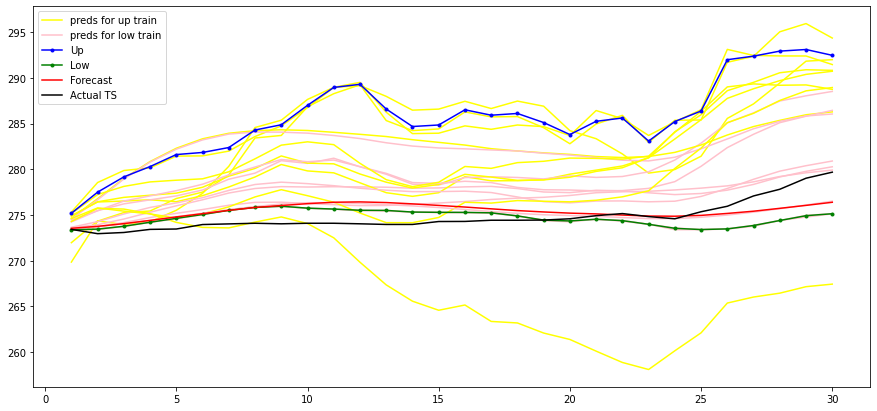

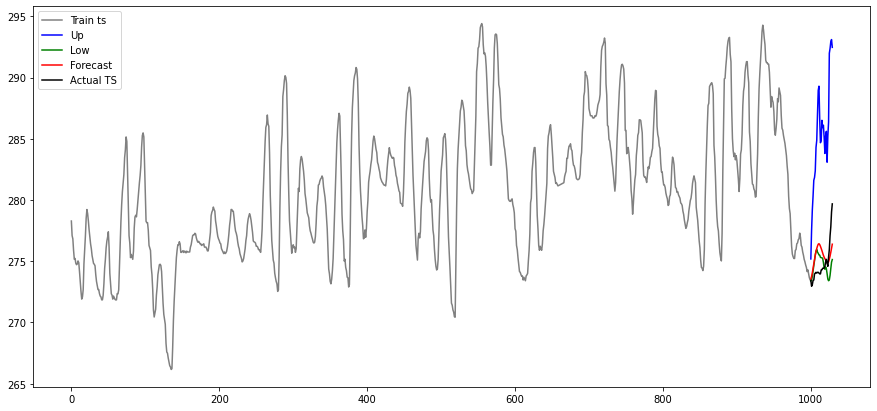

In [68]:
conf_int_plotting(up_predictions = x['up_predictions'],
                  low_predictions = x['low_predictions'],
                  regim='quantile',
                  plot_history = True,
                  plot_up_int = True,
                  plot_low_int = True,
                  plot_trend = False,
                  plot_forecast = True,
                  plot_upper_train = True,
                  plot_lower_train = True,
                  plot_ts_test = True)